In [19]:
using Base: @kwdef
using Parameters: @unpack
using Plots
using LinearAlgebra
using Distributions, Random

In [20]:
# kwdefを使うと初期値の設定をstruct内に入れられる(pythonのコンストラクタっぽく使える)

@kwdef struct DESParameter{FT}
    td::FT = 1e-2
    tr::FT = 5e-3
end

@kwdef mutable struct DES{FT}
    param::DESParameter = DESParameter{FT}()
    N::UInt32 # ニューロンの数
    r_double::Vector{FT} = zeros(N)
    hr::Vector{FT} = zeros(N)
end 

#ifelse(条件式, 条件が一致した場合の処理, 条件が一致しなかった場合の処理)
function DESupdate!(variable::DES, param::DESParameter, r_double, hr, spike::Vector, dt)
    @unpack N = variable
    @unpack td, tr = param
    
    @inbounds @simd for i = 1:N
        #v[i] += dt * ((vrest - v[i] + I[i]) / tc_m) # 不応期がない場合
        r_double[i] = r_double[i]*(1-dt/tr) + hr[i]*dt
        hr[i] = hr[i]*(1-dt/td) + spike[i]/(tr*td)
    end
end

DESupdate! (generic function with 1 method)

In [21]:
# 遅延時間をバラバラにしたい場合は、for loopが必須になるので注意

@kwdef mutable struct Delay_Connection{FT}
    N::UInt32 # ニューロンの数
    delay::Float32
    dt::Float32
    nt_delay::UInt32 = round(Int64,delay/dt)
    state::Matrix{Bool} = zeros(N, nt_delay)
    out = zeros(N)
end 

#ifelse(条件式, 条件が一致した場合の処理, 条件が一致しなかった場合の処理)
function Delay_Connection_call!(variable::Delay_Connection, x::Vector{Bool}, dt)
    @unpack N,delay,dt,nt_delay,state,out = variable
    #out = zeros(N, 1) # mutableに置くと毎回初期化されてしまうので注意
    out = state[:, end]
    state[:, 2:nt_delay] = state[:, 1:(nt_delay-1)]　# 配列をずらす(pythonだとこっちの方がnp.rollより早いらしい)
    state[:, 1] = x
    return out
end

Delay_Connection_call! (generic function with 1 method)

In [22]:
# 遅延時間をバラバラにしたい場合は、for loopが必須になるので注意

@kwdef mutable struct Full_Connection{FT}
    N_in::UInt32
    N_out::UInt32
    W::Matrix{FT}
end 

function Full_Connection_backward!(variable::Full_Connection, x)
    @unpack N_in, N_out, W = variable
    #return dot(W',x)
    return W'*x
end

function Full_Connection_call!(variable::Full_Connection, x)
    @unpack N_in, N_out, W = variable
    #return dot(W,x)
    return W*x
end

Full_Connection_call! (generic function with 1 method)

In [23]:
# kwdefを使うと初期値の設定をstruct内に入れられる(pythonのコンストラクタっぽく使える)
@kwdef struct CurrentLIFParameter{FT}
    tref::FT = 1e-3 #不応期(ms)
    tc_m::FT = 1e-2 # 膜時定数(ms)
    vrest::FT = -60 # 静止膜電位(mV)
    vreset::FT = -60 # リセット電位(mV)
    vthr::FT = -50 # 閾膜電位(mV)
    vpeak::FT = 20 # ピーク電位(mV)
end

@kwdef mutable struct CurrentLIF{FT}
    param::CurrentLIFParameter = CurrentLIFParameter{FT}()
    N::UInt32 # ニューロンの数
    v::Vector{FT} = fill(0, N) # 膜電位(mV)
    v_::Vector{FT} = fill(0, N) # 発火電位も記録する変数
    fire::Vector{Bool} = zeros(Bool, N) # 発火
    tlast::Vector{FT} = zeros(N) # 最後の発火時刻(ms)
    tcount::FT = 0 # 時間カウント
end 

In [24]:
#ifelse(条件式, 条件が一致した場合の処理, 条件が一致しなかった場合の処理)
function cupdate!(variable::CurrentLIF, param::CurrentLIFParameter, I::Vector, dt)
    @unpack N, v, v_, fire, tlast, tcount = variable
    @unpack tref, tc_m, vrest, vreset, vthr, vpeak = param
    
    @inbounds @simd for i = 1:N
        #v[i] += dt * ((vrest - v[i] + I[i]) / tc_m) # 不応期がない場合
        v[i] += dt * ((dt*tcount) > (tlast[i] + tref)) * ((vrest - v[i] + I[i]) / tc_m)
    end
    @inbounds @simd for i = i:N
        fire[i] = v[i] >= vthr
        v_[i] = ifelse(fire[i], vpeak, v[i])
        v[i] = ifelse(fire[i], vreset, v[i])
        tlast[i] = ifelse(fire[i], dt*tcount, tlast[i]) # 発火時刻の更新
    end
end

cupdate! (generic function with 1 method)

In [25]:
T = 0.5 # ms
dt = 1e-4 # ms
nt = UInt32(T/dt) # number of timesteps
N_in = 50 # ニューロンの数
N_mid = 4 # ニューロンの数
N_out = 2 # ニューロンの数

# modelの定義
neuron1 = CurrentLIF{Float64}(N=N_mid)
neuron2 = CurrentLIF{Float64}(N=N_out)

synapses1 = DES{Float64}(N=N_in)
r_double1 = zeros(Float64, N_in)
hr1 = zeros(Float64, N_in)
synapses2 = DES{Float64}(N=N_mid)
r_double2 = zeros(Float64, N_mid)
hr2 = zeros(Float64, N_mid)

delay_connection1 = Delay_Connection{Float64}(N=N_in, delay=8e-4, dt=dt)
delay_connection2 = Delay_Connection{Float64}(N=N_mid, delay=8e-4, dt=dt)
initW = nothing

if isnothing(initW)
    full_connection1 = Full_Connection{Float64}(N_in=N_in, N_out=N_mid, W=0.06*rand(N_mid,N_in))
    full_connection2 = Full_Connection{Float64}(N_in=N_mid, N_out=N_out, W=0.06*rand(N_out,N_mid))
else
    full_connection1 = Full_Connection{Float64}(N_in=N_in, N_out=N_mid, W=initW)
    full_connection2 = Full_Connection{Float64}(N_in=N_mid, N_out=N_out, W=initW)
end

Full_Connection{Float64}(0x00000004, 0x00000002, [0.0008095910154936891 0.05538635058021792 0.03028286671756762 0.029994763050971315; 0.020604987764842833 0.01953512616011309 0.008592768494497265 0.011070549482931909])

In [26]:
# 入力刺激
t = Array{Float32}(1:nt)*dt
I = repeat(2f0 * (t .> 0), 1, N_in)  # injection current

v_arr11 = zeros(Float64, nt, N_mid)
v_arr21 = zeros(Float64, nt, N_mid)
v_arr12 = zeros(Float64, nt, N_out)
v_arr22 = zeros(Float64, nt, N_out)
current1 = zeros(Float64, nt, N_in)
current2 = zeros(Float64, nt, N_mid)
    
# 入力のポワソンスパイク
fr_in = 10
#spikes = rand(nt, num_in) .< fr_in*dt
#spikes = ifelse.(rand(N_in) .< fr_in*dt, 1, 0)

i=1;
@time for i in 1:nt
    spikes = ifelse.(rand(N_in) .< fr_in*dt, 1, 0)
    spikes = Array{Bool}(spikes)
    #####################
    #spike->spike
    c1 = Delay_Connection_call!(delay_connection1, spikes, dt)
    #spike->I
    DESupdate!(synapses1, synapses1.param, r_double1, hr1, c1, dt)
    r_double1 = synapses1.r_double 
    hr1 = synapses1.hr
    current1[i,:] = synapses1.r_double
    #I->I(full connection)
    ret = Full_Connection_call!(full_connection1, synapses1.r_double)
    #println(ret)
    #I->v
    cupdate!(neuron1, neuron1.param, ret, dt)
    neuron1.tcount += 1
    #println(neuron1.fire)
    v_arr11[i, :] = neuron1.fire
    v_arr21[i, :] = neuron1.v_
    #####################
    # second
    spikes = neuron1.fire
    #####################
    #spike->spike
    #println(spikes)
    c2 = Delay_Connection_call!(delay_connection2, spikes, dt)
    #spike->I
    DESupdate!(synapses2, synapses2.param, r_double2, hr2, c2, dt)
    r_double2 = synapses2.r_double 
    hr2 = synapses2.hr
    current2[i,:] = synapses2.r_double
    #I->I(full connection)
    ret = Full_Connection_call!(full_connection2, synapses2.r_double)
    #println(ret)
    #I->v
    cupdate!(neuron2, neuron2.param, ret, dt)
    neuron2.tcount += 1
    v_arr12[i, :] = neuron2.fire
    v_arr22[i, :] = neuron2.v_
    spikes = neuron2.fire
    #####################
end

  0.085564 seconds (622.38 k allocations: 26.108 MiB)


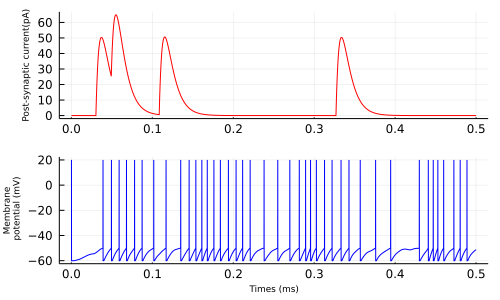

In [27]:
t = Array{Float32}(1:nt)*dt
p1 = plot(t, current1[:, 1], color="red")
p2 = plot(t, v_arr21[:, 1], color="blue")
plot(p1, p2, 
    xlabel = ["" "Times (ms)"], 
    ylabel= ["Post-synaptic current(pA)" "Membrane\n potential (mV)"],
    layout = grid(2, 1, heights=[0.5, 0.5]), guidefont=font(6), legend=false, size=(500,300))

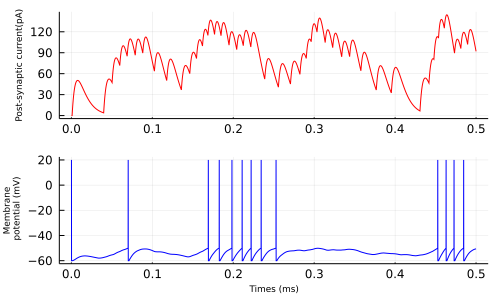

In [28]:
t = Array{Float32}(1:nt)*dt
p1 = plot(t, current2[:, 1], color="red")
p2 = plot(t, v_arr22[:, 1], color="blue")
plot(p1, p2, 
    xlabel = ["" "Times (ms)"], 
    ylabel= ["Post-synaptic current(pA)" "Membrane\n potential (mV)"],
    layout = grid(2, 1, heights=[0.5, 0.5]), guidefont=font(6), legend=false, size=(500,300))